In [1]:
/*************************************************

Analysis of dilepton final state from 13TeV dataset

*************************************************/

#include <iostream>
#include <fstream>
#include <algorithm>

Structure of OpenData (13TeV):
- Data is stored in nTuples, i.e. 'trees'
- One event = one entry in the tree
- One variable = one 'branch' in the tree (branch = integers/floats/vectors/booleans etc.)
- All events have the same branches


TChain is used in order to link together data from several nTuples, i.e. it is a 'chain of trees'.
Would typically like one chain for real data and one for MC (background).

In [2]:
/*

1. Reading the dataset

*/

TChain *background = new TChain("mini");
TChain *data = new TChain("mini");

TChain *background_testing = new TChain("mini");

In [3]:
TString sample; 
TString path; 
TString type;
vector<Int_t> dataset_IDs;
vector<TString> types;
Int_t DSID;

In [4]:
ifstream infile1("../Input/13TeV/dataset_test.txt");

string name ;

In [5]:
infile1.clear();
infile1.seekg(0, ios::beg);  // Start at the beginning of the file

background->Reset(); // Reset the TChain (if necessary)
DSID = 0;

//while (!infile.fail() && !infile.eof() ){
while (infile1 >> sample >> DSID >> type){
        path = "../Input/13TeV/MC/"+sample;
        background->Add(path);
        dataset_IDs.push_back(DSID);
        types.push_back(type);
}

In [6]:
ifstream infile2("../Input/13TeV/dataset_data.txt");

In [7]:
data->Reset();
infile2.clear();
infile2.seekg(0, ios::beg);

while (infile2 >> sample){
        path = "../Input/13TeV/Data/"+sample;
        data->Add(path);
}

In [8]:
// Add individual DSIDs to corresponding types
vector<Int_t> Zjets, ttbar, Dibosons;

In [9]:
Zjets.clear();
ttbar.clear();
Dibosons.clear();

for(int j=0; j<types.size(); j++){
    if (types[j] == "Z+jets"){Zjets.push_back(dataset_IDs[j]); }
    else if (types[j] == "ttbar"){ttbar.push_back(dataset_IDs[j]); }
    else if (types[j] == "Dibosons"){Dibosons.push_back(dataset_IDs[j]); }
}


In [10]:
// Assign branch variables to variables defined below

Int_t lep_n;
Int_t channelNumber;
Float_t XSection, met_et, mcWeight, SumWeights;
Bool_t trigE, trigM;
Int_t lep_type1, lep_type2;
vector<Int_t*> lep_type, lep_charge;
vector<Float_t*> lep_pt, lep_E, lep_phi, lep_eta, lep_etcone20, lep_ptcone30;
vector<Bool_t*> trigMatched, lep_isTightID;

In [11]:
Float_t scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON, scaleFactor_BTAG, scaleFactor_lepTRIGGER;

In [12]:
// For MC:  
background->SetBranchAddress("lep_n",      &lep_n);
background->SetBranchAddress("lep_charge", &lep_charge);
background->SetBranchAddress("lep_type",   &lep_type);
background->SetBranchAddress("lep_pt",     &lep_pt);
background->SetBranchAddress("lep_eta",    &lep_eta);
background->SetBranchAddress("lep_phi",    &lep_phi);
background->SetBranchAddress("lep_E",      &lep_E);
background->SetBranchAddress("met_et",     &met_et); 
background->SetBranchAddress("channelNumber", &channelNumber);
background->SetBranchAddress("mcWeight", &mcWeight);
background->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP );
background->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE ); 
background->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON ); 
background->SetBranchAddress("scaleFactor_BTAG", &scaleFactor_BTAG );
background->SetBranchAddress("scaleFactor_LepTRIGGER", &scaleFactor_lepTRIGGER ); //found
background->SetBranchAddress("lep_isTightID", &lep_isTightID); //will return break->segment violation when running //found, why not largeRjet_tau32 for top-quark tagging (largeRjet = larger jets (R~1, 1.5?))
background->SetBranchAddress("lep_ptcone30", &lep_ptcone30); 
background->SetBranchAddress("lep_etcone20", &lep_etcone20); 
background->SetBranchAddress("trigE", &trigE); //ok
background->SetBranchAddress("trigM", &trigM); //ok
background->SetBranchAddress("SumWeights", &SumWeights); //new
background->SetBranchAddress("XSection", &XSection); //new
//background->SetBranchAddress("jet_MV1", &jet_MV1); //not present in 13TeV dataset

// For data 
data->SetBranchAddress("lep_n",      &lep_n);
data->SetBranchAddress("lep_charge", &lep_charge);
data->SetBranchAddress("lep_type",   &lep_type);
data->SetBranchAddress("lep_pt",     &lep_pt);
data->SetBranchAddress("lep_eta",    &lep_eta);
data->SetBranchAddress("lep_phi",    &lep_phi);
data->SetBranchAddress("lep_E",      &lep_E);
data->SetBranchAddress("met_et",     &met_et); 
data->SetBranchAddress("channelNumber", &channelNumber);
data->SetBranchAddress("trigE", &trigE); 
data->SetBranchAddress("trigM", &trigM);
//data->SetBranchAddress("lep_trigMatched", &lep_trigMatched); //will return break->segment violation when running (not used further down in code)
data->SetBranchAddress("lep_isTightID", &lep_isTightID); ////will return break->segment violation when running //found
data->SetBranchAddress("lep_ptcone30", &lep_ptcone30); //ok
data->SetBranchAddress("lep_etcone20", &lep_etcone20); //ok
//data->SetBranchAddress("jet_MV1", &jet_MV1); //not present in 13TeV dataset

In [13]:
/*

2. Analysis of data and obtaining the desired final states by cuts

*/

// Declaring map containing 1D histograms, in which each histogram contains values of type Int_t.
map<Int_t, TH1*> hist_mll; 
map<Int_t, TH1*> hist_lep_pt; 
map<Int_t, TH1*> hist_met;

// Assign element i to each DSID in dataset_IDs. E.g. dataset_IDs = {1, 2, 3, 4, ...} -> i = {0, 1, 2, 3, ...}
// such that map of hist_mll contains multiple histograms each corresponding to unique tree/DSID (background file).
for(const auto & i:dataset_IDs){
    hist_mll[i] = new TH1F(); 
    hist_lep_pt[i] = new TH1F(); 
    hist_met[i] = new TH1F();
}

for(const auto & i:dataset_IDs){
//    cout << i << endl;
    hist_mll[i]->SetNameTitle("hist_mll", "Invariant mass"); 
    hist_lep_pt[i]->SetNameTitle("hist_lep_pt", "Lepton pT"); 
    hist_met[i]->SetNameTitle("hist_met", "Missing ET");
    hist_mll[i]->SetBins(20,0,500); 
    hist_lep_pt[i]->SetBins(20,0,1000);
    hist_met[i]->SetBins(20,0,500); 
//    cout << i << endl;
}

In [14]:
hist_mll_d = new TH1F(); 
hist_lep_pt_d = new TH1F(); 
hist_met_d = new TH1F();

In [15]:
hist_mll_d->SetNameTitle("hist_mll", "Invariant mass"); 
hist_lep_pt_d->SetNameTitle("hist_lep_pt", "Lepton pT"); 
hist_met_d->SetNameTitle("hist_met", "Missing ET");
hist_mll_d->SetBins(20,0,500); 
hist_lep_pt_d->SetBins(20,0,1000);
hist_met_d->SetBins(20,0,500);

In [16]:
TLorentzVector l1, l2, dileptons;

In [17]:
TChain *dataset = new TChain("mini");
vector<Int_t> DSIDs;
int isData; 
int nentries, nentries_testing;
Float_t W; 
int zjets, Ttbar, dibosons, j;
//int n_bjets, j, a, b, c, d, e, f, g, h, k, l, zjets, Ttbar, dibosons;
Double_t L;   //Integrated luminosity

L = 10000.; //pb
DSIDs.push_back(0);
j = zjets = Ttbar = dibosons = 0;
//j = a = b = c = d = e = f = g = h = k = zjets = Ttbar = dibosons = 0;

In [18]:
// Reset histograms (in case you have filled them before) 
for(const auto & i:dataset_IDs){ 
    hist_mll[i]->Reset(); 
    hist_lep_pt[i]->Reset(); 
    hist_met[i]->Reset();
}

hist_mll_d->Reset(); 
hist_lep_pt_d->Reset(); 
hist_met_d->Reset(); 


// Loop through all events in background and data separately
for(isData = 0; isData<2; isData++){
    if(isData == 1){
        nentries = data->GetEntries();
        dataset = data;
        cout << "Running over data..." << endl; 
    }
    else {
        nentries = background->GetEntries();
        dataset = background;
        cout << "Running over background..." << endl;
    }

    //running over all events within data and background
    for (int i = 0; i < nentries; i++){    //i<nentries      
        if(i%1000000 == 0 && i>0){ cout << i/1000000 << " million events processed" << endl;}

        dataset->GetEntry(i); // We "pull out" the i'th entry in the chain. The variables are now 
                              // available through the names we have given them.
        // Check:
        
       /*
        if(i%1000000 == 0 && i>0){ cout << "lep_n: "<< lep_n << endl;}
        if(i%1000000 == 0 && i>0){ cout << "XSection: " << XSection << endl;}
        if(i%1000000 == 0 && i>0){ cout << "channelNumber: "<< channelNumber << endl;}
        if(i%1000000 == 0 && i>0){ cout << "lep_charge[0]: " << *lep_charge[0] << " lep_charge[1]: " << *lep_charge[1] << endl;}
        if(i%1000000 == 0 && i>0){ cout << "lep_type[0]: " << *lep_type[0] << " lep_type[1]: " << *lep_type[1] << endl;}
        if(i%1000000 == 0 && i>0){ cout << "lep_ptcone30[0]: " << *lep_ptcone30[0] << " lep_ptcone30[1]: " << *lep_ptcone30[1] << endl;}
        if(i%1000000 == 0 && i>0){ cout << "lep_etcone20[0]: " << *lep_etcone20[0] << " lep_etcone20[1]: " << *lep_etcone20[1] << endl;}
        //if(i%1000000 == 0 && i>0){ cout << "lep_isTightID[0]: " << *lep_isTightID[0] << " lep_isTightID[1]: " << *lep_isTightID[1] << endl;}
        if(i%1000000 == 0 && i>0){ cout << "lep_pt[0]: " << *lep_pt[0] << " lep_pt[1]: " << *lep_pt[1] << "\n" << endl;}
        */
        
        // Data quality cut
        //if(trigM == 0 && trigE == 0){ continue; } 
        //l++;
        
        
        // Cut #1: Require (exactly) 2 leptons
        if(lep_n != 2){ continue; }
        // Cut #2: Require opposite charge
        if(*lep_charge[0] == *lep_charge[1]){ continue; }
        // Cut #3: Require same flavour (2 electrons or 2 muons)
        if(*lep_type[0] != *lep_type[1]){ continue; }

        // Require "good leptons": 
        if(*lep_ptcone30[0]/(*lep_pt[0]) > 0.15 ){ continue; }
        if( *lep_etcone20[0]/(*lep_pt[0]) > 0.15 ){ continue; }
        if( *lep_pt[0]/1000.0 < 25 ){ continue; }  //25 GeV = standard cut for triggers for good accuracy

        if( *lep_pt[1]/1000.0 < 25 ){ continue; }
        if( *lep_etcone20[1]/(*lep_pt[1]) > 0.15 ){ continue; }
        if( *lep_ptcone30[1]/(*lep_pt[1]) > 0.15 ){ continue; }

//        if (!(lep_isTightID[1]) == true){continue;}
//        if( !(lep_flag[1] & 512) ){ continue; }
        
        // If an event passes all criterias above then calculate invariant mass, pT and missing transverse E
        
        // Set Lorentz vectors: 
        l1.SetPtEtaPhiE(*lep_pt[0]/1000., *lep_eta[0], *lep_phi[0], *lep_E[0]/1000.);
        l2.SetPtEtaPhiE(*lep_pt[1]/1000., *lep_eta[1], *lep_phi[1], *lep_E[1]/1000.);
        // Variables are stored in the TTree with unit MeV, so we need to divide by 1000 
        // to get GeV, which is a more practical and commonly used unit. 

        
        dileptons = l1 + l2;
        
        if(isData == 1)
        {
            hist_mll_d->Fill(dileptons.M());
            hist_lep_pt_d->Fill(l1.Pt());
            hist_lep_pt_d->Fill(l2.Pt()); 
            hist_met_d->Fill(met_et/1000); 
        }
               
        else
        {
            j++;
            DSIDs.push_back(channelNumber);
            
            if(std::find(Zjets.begin(), Zjets.end(), channelNumber) != Zjets.end()){zjets++; }
            if(std::find(ttbar.begin(), ttbar.end(), channelNumber) != ttbar.end()){Ttbar++; }
            if(std::find(Dibosons.begin(), Dibosons.end(), channelNumber) != Dibosons.end()){dibosons++; }

            // Scaling
            W = (XSection*L/SumWeights)*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_BTAG*scaleFactor_lepTRIGGER; // *scaleFactor_JVFSF*scaleFactor_ZVERTEX; 
            
            hist_mll[channelNumber]->Fill(dileptons.M(), W);
            hist_lep_pt[channelNumber]->Fill(l1.Pt(), W);
            hist_lep_pt[channelNumber]->Fill(l2.Pt(), W);
            hist_met[channelNumber]->Fill(met_et/1000, W);
        }
    }
}
cout << "Done!" << endl;

Running over background...
1 million events processed
2 million events processed
3 million events processed
4 million events processed
5 million events processed
6 million events processed
7 million events processed
8 million events processed
9 million events processed
10 million events processed
11 million events processed
12 million events processed
13 million events processed
14 million events processed
15 million events processed
16 million events processed
17 million events processed
18 million events processed
19 million events processed
20 million events processed
21 million events processed
22 million events processed
23 million events processed
24 million events processed
25 million events processed
26 million events processed
27 million events processed
28 million events processed
29 million events processed
30 million events processed
31 million events processed
32 million events processed
33 million events processed
34 million events processed
35 million events processed
36

In [19]:
cout << "zjets: " << zjets << ", ttbar: " << Ttbar << ", dibosons: " << dibosons << endl;
cout << "DSIDs size: " << DSIDs.size() <<  endl;

zjets: 1624514, ttbar: 24650, dibosons: 650102
DSIDs size: 2299267


In [20]:
/*

3. Assign DSID histograms to corresponding background event histograms.

Make a new set of histograms, each corresponding to the different background categories, instead of the unique
dataset IDs. These histograms are made with the same range and binnings as above.
*/
map<TString, TH1*> H_mll; 
map<TString, TH1*> H_lep_pt;
map<TString, TH1*> H_met;

In [21]:
vector<TString> Backgrounds;

In [22]:
// Must define the proper backgrounds for this dataset
Backgrounds = {"ttbar", "Dibosons", "Zjets"};

In [23]:
for(const auto & i:Backgrounds){
//    cout << i << endl;
    H_mll[i] = new TH1F();
    H_lep_pt[i] = new TH1F(); 
    H_met[i] = new TH1F();
}

for(const auto i:Backgrounds){
    H_mll[i]->Reset();
    H_lep_pt[i]->Reset();
    H_met[i]->Reset();
}


In [24]:
for(const auto & i:Backgrounds){
    H_mll[i]->SetNameTitle("hist_mll", "Invariant mass");
    H_lep_pt[i]->SetNameTitle("hist_lep_pt", "Lepton pT");
    H_met[i]->SetNameTitle("hist_met", "Missing ET");
    H_mll[i]->SetBins(20,0,500); 
    H_lep_pt[i]->SetBins(20,0,1000);
    H_met[i]->SetBins(20,0,500);
}

In [25]:
/*
for(const auto i:Backgrounds){
    H_mll[i]->Reset();
    H_lep_pt[i]->Reset();
    H_met[i]->Reset();
}

for (const auto & type:Background){
    for(const auto & i:dataset_IDs){
        if(std::find(type.begin(), type.end(), i) != type.end()){
            H_mll[type]->Add(hist_mll[i]);
            H_lep_pt[type]->Add(hist_lep_pt[i]);
            H_met[type]->Add(hist_met[i]);
        }
        else{continue; }
    }
}
*/

In [26]:

for(const auto i:Backgrounds){
    H_mll[i]->Reset();
    H_lep_pt[i]->Reset();
    H_met[i]->Reset();
}

for(const auto i:dataset_IDs){
    if(std::find(Zjets.begin(), Zjets.end(), i) != Zjets.end()){
        H_mll["Zjets"]->Add(hist_mll[i]);
        H_lep_pt["Zjets"]->Add(hist_lep_pt[i]);
        H_met["Zjets"]->Add(hist_met[i]);
//        cout << "Found " << i << " in Zjets" << "\n"; 
    }
    else if(std::find(ttbar.begin(), ttbar.end(), i) != ttbar.end()){
        H_mll["ttbar"]->Add(hist_mll[i]); 
        H_lep_pt["ttbar"]->Add(hist_lep_pt[i]);
        H_met["ttbar"]->Add(hist_met[i]);
//        cout << "Found " << i << " in ttbar" << "\n"; 
    }
    else if(std::find(Dibosons.begin(), Dibosons.end(), i) != Dibosons.end()){
        H_mll["Dibosons"]->Add(hist_mll[i]); 
        H_lep_pt["Dibosons"]->Add(hist_lep_pt[i]);
        H_met["Dibosons"]->Add(hist_met[i]);
        cout << i << endl;
        cout << "mll: " << hist_mll[i]->GetEntries() << endl;
        cout << "met: " << hist_met[i]->GetEntries() << endl;
        cout << "lep_pt: " << hist_lep_pt[i]->GetEntries() << endl;
        //        cout << "Found " << i << " in Dibosons" << "\n";  
    }
}


363356
mll: 17699
met: 17699
lep_pt: 35398
363358
mll: 29928
met: 29928
lep_pt: 59856
363359
mll: 4
met: 4
lep_pt: 8
363360
mll: 10
met: 10
lep_pt: 20
363490
mll: 229302
met: 229302
lep_pt: 458604
363491
mll: 293000
met: 293000
lep_pt: 586000
363492
mll: 80159
met: 80159
lep_pt: 160318
363493
mll: 0
met: 0
lep_pt: 0


In [27]:
//Making new map containing the colours wanted for each background process, and set the colours of the histogram

map<TString, Int_t> colors;

colors["Dibosons"] = kGreen; 
colors["Zjets"] = kYellow; 
colors["ttbar"] = kRed;

for(const auto h:Backgrounds){
    H_mll[h]->SetFillColor(colors[h]); 
    H_met[h]->SetFillColor(colors[h]);
    H_lep_pt[h]->SetFillColor(colors[h]);
    
    H_mll[h]->SetLineColor(colors[h]); 
    H_met[h]->SetLineColor(colors[h]);
    H_lep_pt[h]->SetLineColor(colors[h]);
}

In [28]:
/*

4. Stack and plot the histograms

For each variable we need to stack the backgrounds on top of each other, which is done by using the THStack class. 
In the example below we do this for two variables; invariant mass and missing ET.

*/

THStack *stack_mll = new THStack("Invariant mass", "");
THStack *stack_met = new THStack("Missing ET", ""); 
THStack *stack_lep_pt = new THStack("Lepton pT", "");

for(const auto h:Backgrounds){
    stack_mll->RecursiveRemove(H_mll[h]); // Remove previously stacked histograms  
    stack_met->RecursiveRemove(H_met[h]);
    stack_lep_pt->RecursiveRemove(H_lep_pt[h]);
    stack_mll->Add(H_mll[h]); //Add new stacked histograms
    stack_met->Add(H_met[h]);
    stack_lep_pt->Add(H_lep_pt[h]); 
}


In [29]:
gStyle->SetLegendBorderSize(0); // Remove (default) border around legend
TLegend *leg = new TLegend(0.65, 0.60, 0.9, 0.85);

In [30]:
leg->Clear();
for(const auto i:Backgrounds){
    leg->AddEntry(H_mll[i], i, "f");  // Add your histograms to the legend
}
leg->AddEntry(hist_mll_d, "Data", "lep");

In [31]:
TCanvas *C = new TCanvas("c", "c", 600, 600);
gPad->SetLogy(); // Set logarithmic y-axis

In [32]:
hist_mll_d->SetLineColor(kBlack);
hist_mll_d->SetMarkerStyle(kFullCircle);
hist_mll_d->SetMarkerColor(kBlack);

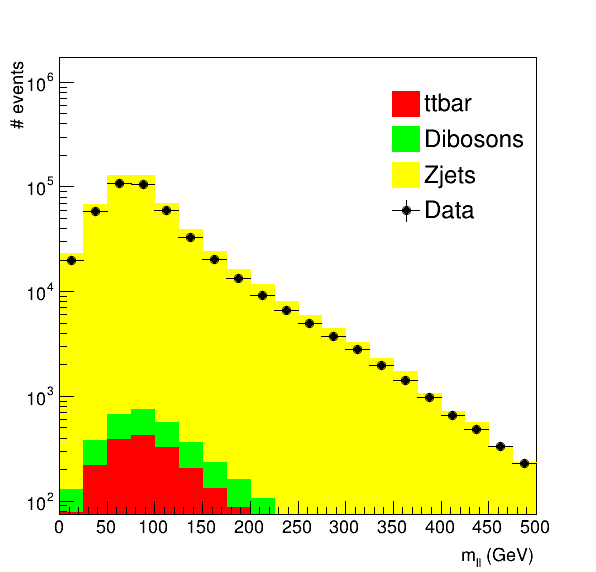

In [33]:
stack_mll->Draw("hist");
stack_mll->SetMaximum(1E6);     //set maximum range on axis
stack_mll->GetYaxis()->SetTitle("# events");
stack_mll->GetYaxis()->SetTitleOffset(1.3);
stack_mll->GetXaxis()->SetTitle("m_{ll} (GeV)");
stack_mll->GetXaxis()->SetTitleOffset(1.3);
hist_mll_d->Draw("same E");
leg->Draw();
C->Draw();

/*
If there are less statistics, then it is more likely that the MC samples and real data will differ as 
MC predicts the amount of events one can expect at a certain range of e.g. m_ll. As long as the number of 
events of MC and real data do not differ too much at high statistics, e.g. 10^6 events,
then MC is correct. If they do, then there is something wrong with the theory modelling the MC.
*/

In [34]:
hist_met_d->SetLineColor(kBlack);
hist_met_d->SetMarkerStyle(kFullCircle);
hist_met_d->SetMarkerColor(kBlack);

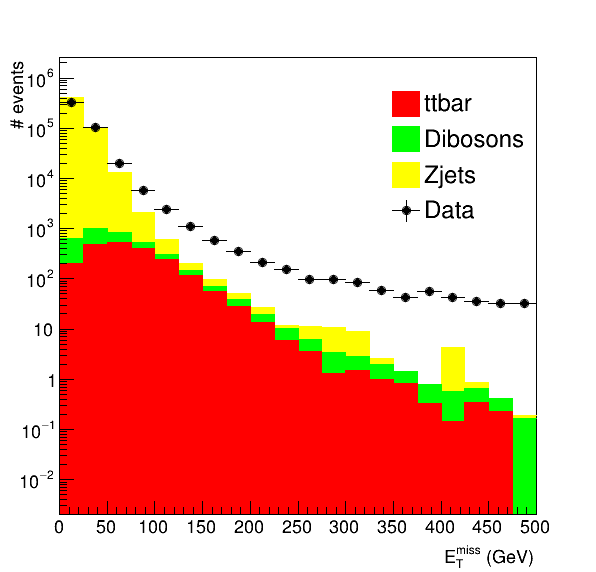

In [35]:
stack_met->Draw("hist"); 
stack_met->SetMaximum(1E6);
stack_met->SetMinimum(1E-2); 
stack_met->GetYaxis()->SetTitle("# events");
stack_met->GetYaxis()->SetTitleOffset(1.3); 
stack_met->GetXaxis()->SetTitle("E_{T}^{miss} (GeV)");
stack_met->GetXaxis()->SetTitleOffset(1.3);
hist_met_d->Draw("same e");
leg->Draw();
C->Draw();

/*
Often more difficult to model E_miss
*/

In [36]:
hist_lep_pt_d->SetLineColor(kBlack); 
hist_lep_pt_d->SetMarkerStyle(kFullCircle); 
hist_lep_pt_d->SetMarkerColor(kBlack);

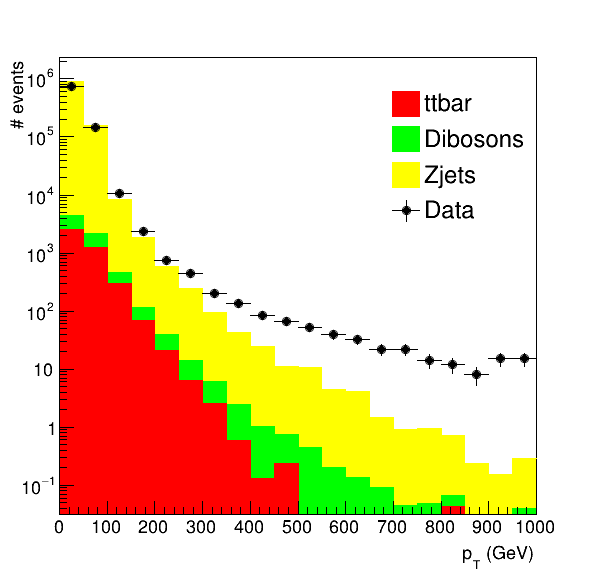

In [37]:
stack_lep_pt->Draw("hist"); 
stack_lep_pt->SetMaximum(1E6); 
stack_lep_pt->GetYaxis()->SetTitle("# events");
stack_lep_pt->GetYaxis()->SetTitleOffset(1.3); 
stack_lep_pt->GetXaxis()->SetTitle("p_{T} (GeV)");
stack_lep_pt->GetXaxis()->SetTitleOffset(1.3);
hist_lep_pt_d->Draw("same e"); 
leg->Draw();
C->Draw();

/*
natural to also include ratio of events between data/MC --> Add another pad to the canvas including this!
*/

In [38]:
//cout << "Dibosons H_met: " << H_met.GetEntries() << " entries"<< endl;